# k-Nearest Neighbor exercise

The k-nearest neighbors (KNN) algorithm is a simple supervised machine learning algorithm. kNN assumes that similar things exist in close proximity. In other words, similar things are "near" to each other. 

In training stage, the kNN classifier takes the training data and simply remembers it. Then, in testing stage, the classifier looks through the training data and finds the *k* training examples that are **nearest** to the new example based on certain metrics. It then assigns the most common class label (among those *k* training examples) to the test example.

Mathematically, for a given example $x$, the output of kNN is the class $y$ with the largest probability:

$$
P(y=j \mid X=x)=\frac{1}{K} \sum_{i \in \mathcal{A}} I\left(y^{(i)}=j\right)
$$

where $\mathcal{A}$ is the *k* nearest neighbors of $x$

The target of this assignment is to develop a kNN classifier for [MNIST](http://yann.lecun.com/exdb/mnist/) handwritten digit classification.

## Table of Contents

- [1-Packages](#1)
- [2-Load the Dataset](#2)
- [3-kNN Classifier](#3)
- [4-Test the classifier](#4)
- [5-Test with different k value](#5)

<a name='1'></a>
## 1 - Packages

First import all the packages needed during this assignment

In [1]:
import subprocess
import struct
import numpy as np
import os
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm

%matplotlib inline

%load_ext autoreload
%autoreload 2

<a name='2'></a>
## 2 - Load the Dataset 

In [2]:
remote_url = 'http://yann.lecun.com/exdb/mnist/'
files = ('train-images-idx3-ubyte.gz', 'train-labels-idx1-ubyte.gz',
         't10k-images-idx3-ubyte.gz', 't10k-labels-idx1-ubyte.gz')

save_path = 'mnist'
os.makedirs(save_path, exist_ok=True)

# Download MNIST dataset
for file in files:
    data_path = os.path.join(save_path, file)
    if not os.path.exists(data_path):
        url = remote_url + file
        print(f'Downloading {file} from {url}')
        subprocess.call(['wget', '--quiet', '-O', data_path, url])
        print(f'Finish downloading {file}')

# Extract zip files
subprocess.call(f'find {save_path}/ -name "*.gz" | xargs gunzip -f', shell=True);

Finish downloading train-images-idx3-ubyte.gz
Finish downloading train-labels-idx1-ubyte.gz
Finish downloading t10k-images-idx3-ubyte.gz
Finish downloading t10k-labels-idx1-ubyte.gz


For convenience, images are reshaped to column vector. Data is represented in `np.array` format.

In [3]:
mnist_prefixs = ['train_images', 'train_labels', 't10k_images', 't10k_labels']
result = dict.fromkeys(mnist_prefixs)

for file in os.listdir(save_path):
    with open(os.path.join(save_path, file), 'rb') as f:
        prefix = '_'.join(file.split('-')[:2])
        if 'labels' in prefix:
            magic_num, size = struct.unpack('>II', f.read(8))
            result[prefix] = np.fromfile(f, dtype=np.uint8)
        elif 'images' in prefix:
            magic_num, size, rows, cols = struct.unpack('>IIII', f.read(16))
            # reshape to column vector
            result[prefix] = np.fromfile(f, dtype=np.uint8).reshape(size, -1) / 255  
        else:
            raise Exception(f'Unexpected filename: {file}')

train_img, train_label, test_img, test_label = (result[key] for key in mnist_prefixs)

In [4]:
# As a sanity check, print out the size of the training and test data
print('Training data shape: ', train_img.shape)
print('Training labels shape: ', train_label.shape)
print('Test data shape: ', test_img.shape)
print('Test labels shape: ', test_label.shape)

Training data shape:  (60000, 784)
Training labels shape:  (60000,)
Test data shape:  (10000, 784)
Test labels shape:  (10000,)


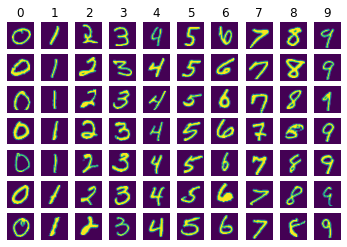

In [5]:
# Visualize some examples from the dataset
classes = list(range(0, 10))
num_classes = len(classes)
sample_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(train_label == cls)
    idxs = np.random.choice(idxs, sample_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(sample_per_class, num_classes, plt_idx)
        img_size = int(np.sqrt(train_img[idx].shape[-1]))
        plt.imshow(train_img[idx].reshape(img_size, img_size))
        plt.axis('off')
        if i == 0:
            plt.title(cls)

<a name='3'></a>
## 3 - kNN Classifier

Recall that kNN works by finding the **distance** (or **similarity**) among a query and all the examples in the data. Thus, a metrics of distance (or similarity) between examples is required. In the assignment, we use `L2 distance` as the distance metrics among examples. Other metrices like `L1 distance` or `cosine similarity` are also available, which could be done with slight modification to the code.

L2 distance:
\begin{align*}
d(\mathbf{p}, \mathbf{q})=d(\mathbf{q}, \mathbf{p}) &=\sqrt{\sum_{i=1}^{n}\left(q_{i}-p_{i}\right)^{2}}
\end{align*}

In [6]:
def classify_10(data, label, img, k):
    """MNIST digit classification using kNN algorithm"""
    
    # Calculate L2 distance between given image and all training data
    d_1 = np.abs(data - img)
    d_2 = d_1 ** 2
    d_3 = d_2.sum(axis=1)
    
    # Find out the closest k examples
    k_N = Counter(label[d_3.argsort()][:k])
    return sorted(k_N, key=lambda x: k_N[x], reverse=True)[0]

def kNN(train_img, train_label, test_img, test_label, k):
    error_count = 0
    acc_rate = 1.0
    prediction = []
    pbar = tqdm(enumerate(test_img), total=test_img.shape[0])
    for i, img in pbar:
        pred = classify_10(train_img, train_label, img, k)
        prediction.append(pred)
        if pred != test_label[i]:
            error_count += 1
        acc_rate = 1 - 1.0 * error_count / (i + 1)
        pbar.set_postfix_str(f'accuracy: {acc_rate}', refresh=False)
        pbar.update(1)
    return prediction

<a name='4'></a>
## 4 - Test the classifier

In [7]:
pred = kNN(train_img, train_label, test_img, test_label, k=3) # Test kNN with k=3
acc = np.mean(pred == test_label)
print('Accuracy: %.6f' % acc)

100%|██████████| 10000/10000 [35:55<00:00,  4.64it/s, accuracy: 0.9717]            

Accuracy: 0.971700


<a name='5'></a>
## 5 - Test with different k value

In [8]:
# Try to determine the optimal value of k
k_choices = (3, 5, 7, 9)
accuracy = []
for k in k_choices:
    pred = kNN(train_img, train_label, test_img, test_label, k=k)
    accuracy.append(np.mean(pred == test_label))
    print('k = %d; Accuracy: %.6f' % (k, accuracy[-1]))

optimal_k = k_choices[np.array(accuracy).argmax()]
print(f'optimal value of k in {k_choices} is {optimal_k}')

  0%|          | 0/10000 [00:00<?, ?it/s]

k = 3; Accuracy: 0.971700


  0%|          | 0/10000 [00:00<?, ?it/s]

k = 5; Accuracy: 0.969300


  0%|          | 0/10000 [00:00<?, ?it/s]

k = 7; Accuracy: 0.969900


100%|██████████| 10000/10000 [35:36<00:00,  4.68it/s, accuracy: 0.9669]            

k = 9; Accuracy: 0.966900
optimal value of k in (3, 5, 7, 9) is 3


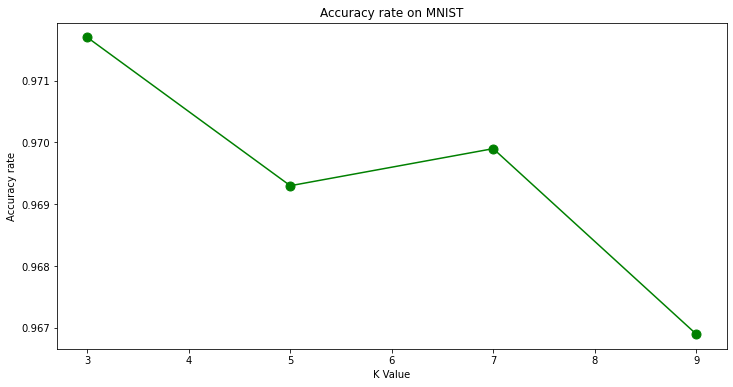

In [9]:
# Plot the accuracy rate with different k value
plt.figure(figsize=(12, 6))
plt.plot(k_choices, accuracy, color='green', marker='o', markersize=9)
plt.title('Accuracy rate on MNIST')
plt.xlabel('K Value')
plt.ylabel('Accuracy rate')
plt.show()